# Preliminaries


[Catalog of sources](https://cdsarc.unistra.fr/viz-bin/cat/J/A%2bA/628/A66)

Not sure how to render this:
```
@MISC{ vizier:J/A+A/628/A66, 
author = {Lodieu N., Perez-Garrido A., Smart R.L., Silvotti, R.}, 
title = "{VizieR Online Data Catalog: alpha Persei, Pleiades and Praesepe clusters}", 
year = "2019", 
doi = {10.26093/cds/vizier.36280066}, 
journal = {\aap}
}
```

In [1]:
import astropy.coordinates as coord
from astropy.table import QTable, vstack

import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import pandas as pd
import pickle
import os

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np

In [3]:
from cluster import cluster as cl
from fieldstars import fieldstars as fs

# Get Lodieu Data Files

Details of processing these data files are [here](https://drive.google.com/file/d/1-BXGwshTcOD1bptRXy_pKGCemQnDY22z/view?usp=sharing)


In [4]:
alpha_per_lodieu = cl('alpha_per','./data/J_A+A_628_A66')

In [5]:
#column mapper to map to field star class
colmapper= {'source_id':'SourceCP', 'ra':'RAdeg', 'dec':'DEdeg','parallax':'Plx',
            'pmra':'pmRA', 'pmdec':'pmDE', 'radial_velocity':'RVCP',
            'phot_g_mean_mag':'Gmag', 'phot_bp_mean_mag':'BPmag', 'phot_rp_mean_mag':'RPmag','r_est':'rest'}

In [27]:
from fieldstars import from_pandas
alpha_per=from_pandas(alpha_per_lodieu.objs, colmapper, name='lodieu')

### Cut the data by distance from Cluster Center

In [28]:
cuts = np.array([0,2.3,5.6, 9.5, 28.5,50,75,100])
labs = [f'Within {d} pc' for d in cuts[1:]]
#sm = cm.ScalarMappable(cmap=cm.Set1)
#bin_colors = sm.to_rgba(range(len(labs)), alpha=0.8)
bin_colors = ['black', 'blue', 'green', 'red','magenta','orange', 'yellow']
alpha_per_lodieu.objs['DistanceBin']  =pd.cut(alpha_per_lodieu.objs.distC, cuts, labels=labs)


In [29]:
alpha_per_lodieu.objs.DistanceBin.value_counts()

Within 28.5 pc     1552
Within 50.0 pc     1060
Within 9.5 pc       293
Within 5.6 pc       201
Within 2.3 pc        23
Within 75.0 pc        9
Within 100.0 pc       4
Name: DistanceBin, dtype: int64

# Lodieu Plots

The plots below reproduce Figure A.1 in Appendix A of Lodieu's paper. Not all of the 3,162 objects in the data file are plotted, just the 2,069 objects within 28.5 parsecs of $\alpha Per$ center in keeping with the Lodieu's methodology.

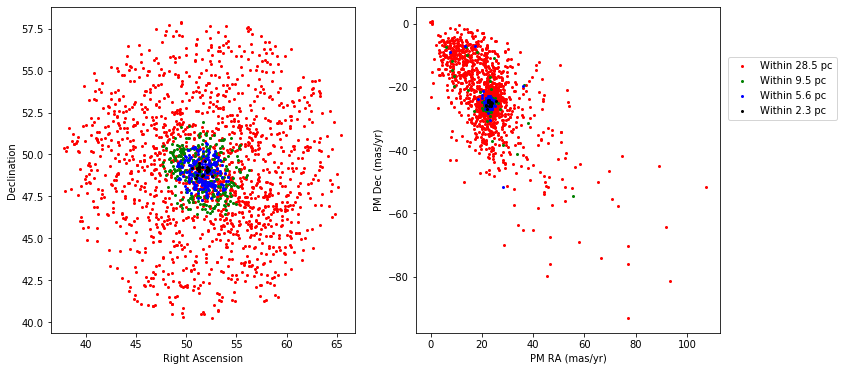

In [30]:
#@title RA, Dec, and PM

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(3,-1,-1):
  pdf = alpha_per_lodieu.objs.query('DistanceBin == @labs[@i]')
  ax[0].scatter(pdf.RAdeg, pdf.DEdeg, color=bin_colors[i], label=labs[i], s=4)
#ax[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[0].set_xlabel('Right Ascension')
_=ax[0].set_ylabel('Declination')

for i in range(3,-1,-1):
  pdf = alpha_per_lodieu.objs.query('DistanceBin == @labs[@i]')
  ax[1].scatter(pdf.pmRA, pdf.pmDE, color=bin_colors[i], label=labs[i], s=4)
ax[1].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[1].set_xlabel('PM RA (mas/yr)')
_=ax[1].set_ylabel('PM Dec (mas/yr)')


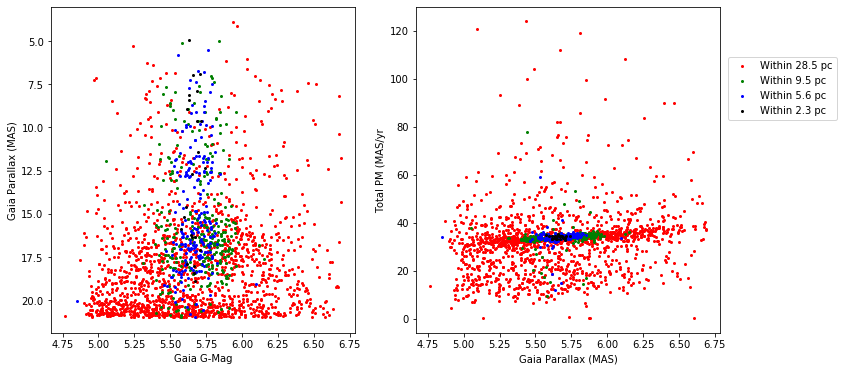

In [31]:
#@title Magnitude and PM v. Parallax

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(3,-1,-1):
  pdf = alpha_per_lodieu.objs.query('DistanceBin == @labs[@i]')
  ax[0].scatter(pdf.Plx, pdf.Gmag, color=bin_colors[i], label=labs[i], s=4)
#ax[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[0].set_xlabel('Gaia G-Mag')
ax[0].invert_yaxis()
_=ax[0].set_ylabel('Gaia Parallax (MAS)')

for i in range(3,-1,-1):
  pdf = alpha_per_lodieu.objs.query('DistanceBin == @labs[@i]')
  ax[1].scatter(pdf.Plx,
                np.sqrt(pdf.pmRA**2 + pdf.pmDE**2),
                 color=bin_colors[i], label=labs[i], s=4)
ax[1].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[1].set_ylabel('Total PM (MAS/yr')
_=ax[1].set_xlabel('Gaia Parallax (MAS)')

Text(0.5, 1.0, 'Count by Distance Bin')

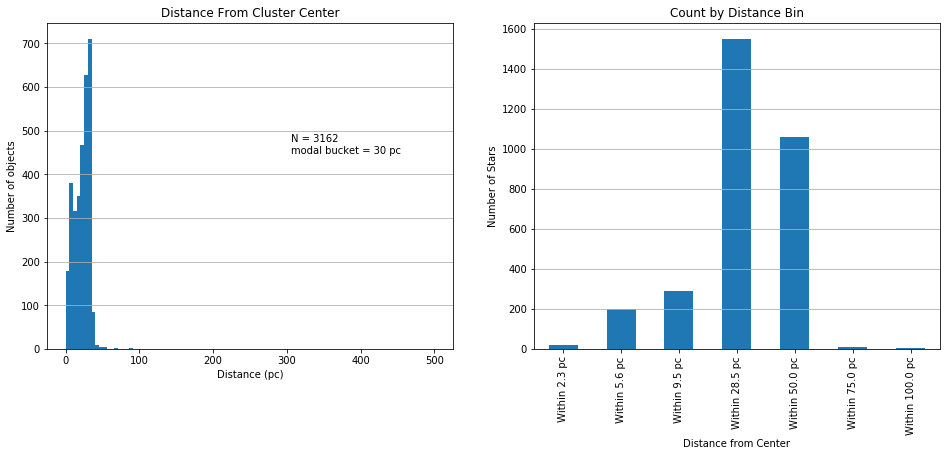

In [32]:
#@title Distance from Center Histograms
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
zz=ax[0].hist(alpha_per_lodieu.objs.distC, bins=np.linspace(0,500,100, endpoint=True))
ax[0].set_ylabel('Number of objects')
un = u.parsec
ax[0].set_xlabel(f'Distance ({un})')
ax[0].set_title('Distance From Cluster Center')
N = len(alpha_per_lodieu.objs)
mode = zz[1][zz[0].argmax()]
ax[0].text(0.60, 0.60,f'N = {N}\nmodal bucket = {mode:.0f} pc',transform=ax[0].transAxes)
ax[0].grid(axis='y')
#ax.axvline(alf_per_dist, color='red',label=r'$\alpha Per$')
#ax.legend()

alpha_per_lodieu.objs.groupby('DistanceBin').size().plot(kind='bar', ax=ax[1])
ax[1].set_ylabel('Number of Stars')
ax[1].set_xlabel('Distance from Center')
ax[1].grid(axis='y')
ax[1].set_title("Count by Distance Bin")

# Get Stars in the Vicinity of $\alpha Per$

Get field stars in the vicinity of $\alpha Per$. See the notebook [alpha_per_vicinity](./alpha_per_vicinity.ipynb) for the derivation of the parameters of the conesearch query. The results of the conesearch query have been saved off in a pickle file and are read back in here.

In [12]:
from fieldstars import from_pickle
import os

v_name = 'alpha_per_vicinity'
v_path = os.path.join('./data',v_name+'.pkl')
alpha_per_vicinity = from_pickle(v_path)
print(f'{alpha_per_vicinity.name} contains {len(alpha_per_vicinity.objs)} objs')

alpha_per_vicinity contains 47399 objs


### Make Consolidated Data Frame

In [33]:
consol_fs = alpha_per_vicinity.merge(alpha_per)

In [34]:
consol_fs.objs._merge.value_counts()

left_only     45112
both           2287
right_only      875
Name: _merge, dtype: int64

In [35]:
consol_fs.objs.query('which == \'lodieu\'').head()

,_merge,which,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,r_est
source_id,,,,,,,,,,,,
142839204833313408,right_only,lodieu,45.528660,39.168667,5.5849,7.028,-16.292,-9999.0,20.7358,21.193600,19.559299,580.823
142942627646175104,right_only,lodieu,45.778371,39.477138,5.3342,6.980,-12.677,-9999.0,20.7254,21.044701,20.805799,407.573
143481701875966592,right_only,lodieu,43.921781,39.802850,5.7946,12.688,-9.771,-9999.0,20.4017,21.095699,19.008400,215.083
143595707487785856,right_only,lodieu,45.358971,39.384358,5.6180,5.195,-6.908,-9999.0,20.9837,20.517200,19.780300,834.562
143690712164105728,right_only,lodieu,44.899103,40.114218,5.7505,9.647,-12.088,-9999.0,20.4038,21.398399,19.030100,215.054


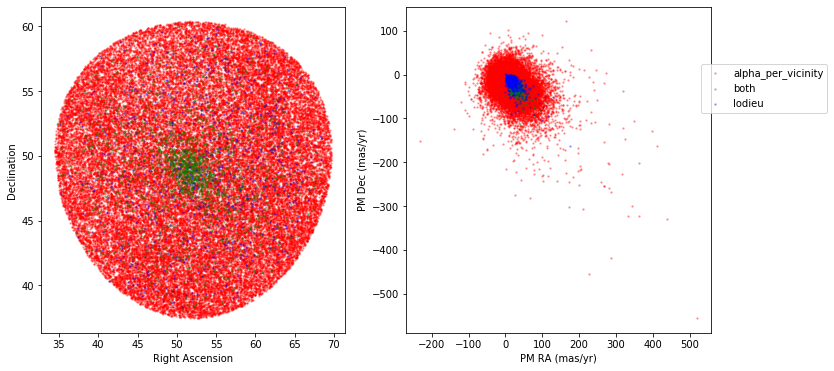

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for s,c in zip(['alpha_per_vicinity','both','lodieu',],['red','green','blue']):
  pdf = consol_fs.objs.query('which == @s')
  ax[0].scatter(pdf.ra, pdf.dec, color=c, label=s, s=2, alpha=0.3)
#ax[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[0].set_xlabel('Right Ascension')
_=ax[0].set_ylabel('Declination')

for s,c in zip(['alpha_per_vicinity','both','lodieu',],['red','green','blue']):
  pdf = consol_fs.objs.query('which == @s')
  ax[1].scatter(pdf.pmra, pdf.pmdec, color=c, label=s, s=2, alpha=0.3)
ax[1].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[1].set_xlabel('PM RA (mas/yr)')
_=ax[1].set_ylabel('PM Dec (mas/yr)')


In [37]:
consol_fs.objs.query('which == \'lodieu\'').head()

,_merge,which,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,r_est
source_id,,,,,,,,,,,,
142839204833313408,right_only,lodieu,45.528660,39.168667,5.5849,7.028,-16.292,-9999.0,20.7358,21.193600,19.559299,580.823
142942627646175104,right_only,lodieu,45.778371,39.477138,5.3342,6.980,-12.677,-9999.0,20.7254,21.044701,20.805799,407.573
143481701875966592,right_only,lodieu,43.921781,39.802850,5.7946,12.688,-9.771,-9999.0,20.4017,21.095699,19.008400,215.083
143595707487785856,right_only,lodieu,45.358971,39.384358,5.6180,5.195,-6.908,-9999.0,20.9837,20.517200,19.780300,834.562
143690712164105728,right_only,lodieu,44.899103,40.114218,5.7505,9.647,-12.088,-9999.0,20.4038,21.398399,19.030100,215.054


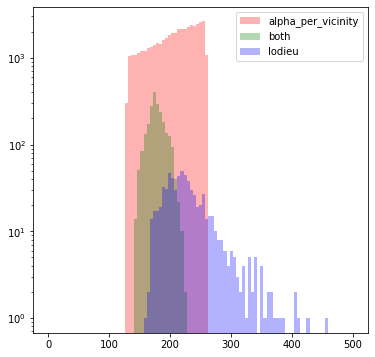

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for s,c in zip(['alpha_per_vicinity','both','lodieu',],['red','green','blue']):
  pdf = consol_fs.objs.query('which == @s')
  ax.set_yscale('log')
  ax.hist(pdf.r_est,bins=np.linspace(0,500,100, endpoint=True), color=c, label=s,  alpha=0.3)
ax.legend()

In [39]:
consol_fs.objs.query('r_est >= 165.15045  and r_est <=201.85055').which.value_counts()

alpha_per_vicinity    11108
both                   1716
lodieu                  176
Name: which, dtype: int64

The output above shows that (only?) about 10% of Lodieu's object are unmatched in the vicinity of the median distance.

In [43]:
#build balanced data frame

#columns used in subsequent classifiers:
col_list = ['which','pmra','pmdec','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag']
consol_df = consol_fs.objs[col_list]

#members: objects of lodieu's list that are matched in vicinity objects
members = consol_df.query('which==\'both\'')
n_both = len(members)

#non-members: objects in the vicinity unmatched by members of Lodieu's list
#there are a lot of these, so randomly pick as many non-members as there are members:
non_members = consol_df.query('which==\'alpha_per_vicinity\'').sample(n=n_both, random_state=1234)

#paste the two lists together
balanced_df = pd.concat([members, non_members])

#shuffle it up
np.random.seed(4321)
balanced_df = balanced_df.loc[np.random.permutation(balanced_df.index)]

#ditch rows with NaNs
n_before = len(balanced_df)
balanced_df.dropna(inplace=True)
n_after = len(balanced_df)
print(f'{n_before-n_after} of {n_before} rows dropped due to missing values')


#binary value for candidacy
balanced_df['candidate'] = np.where(balanced_df.which == 'both', 1, 0)

balanced_df.which.value_counts()

57 of 4574 rows dropped due to missing values


both                  2287
alpha_per_vicinity    2230
lodieu                   0
Name: which, dtype: int64

In [44]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4517 entries, 230762962117395200 to 249605391662789120
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   which             4517 non-null   category
 1   pmra              4517 non-null   float64 
 2   pmdec             4517 non-null   float64 
 3   phot_g_mean_mag   4517 non-null   float64 
 4   phot_bp_mean_mag  4517 non-null   float64 
 5   phot_rp_mean_mag  4517 non-null   float64 
 6   candidate         4517 non-null   int64   
dtypes: category(1), float64(5), int64(1)
memory usage: 251.5 KB


In [45]:
np.any(balanced_df.phot_g_mean_mag==-9999.0)

False

In [46]:
# partition to train, val and test dataframes
test_frac = 0.2; train_frac = 0.65; val_frac = 1.0 - test_frac - train_frac
nrows = len(balanced_df)
test_n = int(test_frac*nrows); train_n=int(train_frac*nrows); val_n=nrows-test_n-train_n

train_df = balanced_df.iloc[:train_n]
val_df = balanced_df.iloc[train_n:train_n+val_n]
test_df = balanced_df.iloc[train_n+val_n:]

len(train_df), len(val_df), len(test_df), nrows

(2936, 678, 903, 4517)

# Classifier Models

In [47]:
# some needed libraries
from sklearn.model_selection import train_test_split # to partition the dataset into training and test
from sklearn.metrics import accuracy_score, confusion_matrix # for model evaluation
from sklearn.linear_model import LogisticRegression # classifier model to test

In [52]:
# function to create features from input data set
# returns (n,4) feature matrix and (n,) label vector
def get_features_labels(df):
    features = np.zeros((len(df), 5))
    features[:,0] = np.array(df.pmra)
    features[:,1] = np.array(df.pmdec)
    features[:,2] = np.array(df.phot_bp_mean_mag - df.phot_g_mean_mag)
    features[:,3] = np.array(df.phot_g_mean_mag - df.phot_rp_mean_mag)
    features[:,4] = np.array(np.sqrt(df.pmra**2+df.pmdec**2))
    labels = np.array(df.candidate)
    return features, labels

In [53]:
#get the features and labels for each of the sets
x_train,  y_train  = get_features_labels(train_df)
x_val,  y_val  = get_features_labels(val_df)
x_test, y_test = get_features_labels(test_df)

## Logit Classifier

In [54]:
logit_model = LogisticRegression()
logit_model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
# calculate prediction accuracy on the dev set
pred_ovr_train = logit_model.predict(x_train)
acc_ovr_train = accuracy_score(y_train, pred_ovr_train)

#calculate prediction accuracy on the validation set
pred_ovr_val = logit_model.predict(x_val)
acc_ovr_val = accuracy_score(y_val, pred_ovr_val)

print('OVR Training Set Accuracy: ', acc_ovr_train)
print('OVR Validation Set Accuracy: ', acc_ovr_val)

OVR Training Set Accuracy:  0.8170980926430518
OVR Validation Set Accuracy:  0.8200589970501475


In [56]:
confusion_matrix(y_val, pred_ovr_val)

array([[229, 105],
       [ 17, 327]])

In [57]:
logit_model.classes_

array([0, 1])

## K Nearest Neighbors

In [58]:
from sklearn.neighbors import KNeighborsClassifier

In [59]:
neighbors = KNeighborsClassifier()
neighbors.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [60]:
# calculate prediction accuracy on the dev set
pred_knn_train = neighbors.predict(x_train)
acc_knn_train = accuracy_score(y_train, pred_knn_train)

#calculate prediction accuracy on the validation set
pred_knn_val = neighbors.predict(x_val)
acc_knn_val = accuracy_score(y_val, pred_knn_val)

print('KNN Training Set Accuracy: ', acc_knn_train)
print('KNN Validation Set Accuracy: ', acc_knn_val)

KNN Training Set Accuracy:  0.8995231607629428
KNN Validation Set Accuracy:  0.8672566371681416


In [61]:
confusion_matrix(y_val, pred_knn_val)

array([[280,  54],
       [ 36, 308]])

## Decision Tree Classifier

In [62]:
from sklearn.tree import DecisionTreeClassifier

In [63]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [64]:
# calculate prediction accuracy on the dev set
pred_dtc_train = dtc.predict(x_train)
acc_dtc_train = accuracy_score(y_train, pred_dtc_train)

#calculate prediction accuracy on the validation set
pred_dtc_val = dtc.predict(x_val)
acc_dtc_val = accuracy_score(y_val, pred_dtc_val)

print('DTC Training Set Accuracy: ', acc_dtc_train)
print('DTC Validation Set Accuracy: ', acc_dtc_val)

DTC Training Set Accuracy:  1.0
DTC Validation Set Accuracy:  0.8613569321533924


## Ensemble

In [65]:
def ensemble(modlist, X):
  """
  only works for binary classifiers
  """
  thresh = np.ceil(len(modlist)/2.0)
  yhat = np.array([m.predict(X) for m in modlist])
  yhat_ens = np.where(yhat.sum(axis=0)>=thresh,1,0)
  return yhat_ens


In [66]:
modlist = [logit_model, neighbors, dtc]

In [67]:
# calculate prediction accuracy on the dev set
pred_ens_train = ensemble(modlist, x_train)
acc_ens_train = accuracy_score(y_train, pred_ens_train)

#calculate prediction accuracy on the validation set
pred_ens_val = ensemble(modlist, x_val)
acc_ens_val = accuracy_score(y_val, pred_ens_val)

print('ENS Training Set Accuracy: ', acc_ens_train)
print('ENS Validation Set Accuracy: ', acc_ens_val)

ENS Training Set Accuracy:  0.9339237057220708
ENS Validation Set Accuracy:  0.8893805309734514


In [68]:
confusion_matrix(y_val, pred_ens_val)

array([[278,  56],
       [ 19, 325]])

In [69]:
confusion = pd.DataFrame([confusion_matrix(y_val, pred_ovr_val).flatten(),
                          confusion_matrix(y_val, pred_knn_val).flatten(),
                          confusion_matrix(y_val, pred_dtc_val).flatten(),
                          confusion_matrix(y_val, pred_ens_val).flatten()],
                    index=['LogitRegr','KNN', 'DTC', 'Ens'],
                    columns = ['Tpos','Fneg','Fpos','Tneg'])

In [70]:
confusion

,Tpos,Fneg,Fpos,Tneg
LogitRegr,229,105,17,327
KNN,280,54,36,308
DTC,288,46,48,296
Ens,278,56,19,325


In [71]:
acc_ens_train.shape, pred_dtc_train.shape

((), (2936,))

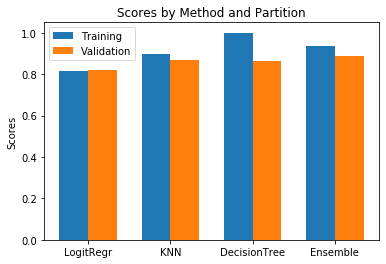

In [72]:
train_acc = (acc_ovr_train, acc_knn_train, acc_dtc_train, acc_ens_train)
val_acc = (acc_ovr_val, acc_knn_val, acc_dtc_val, acc_ens_val)

ind = np.arange(len(train_acc))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, train_acc, width, 
                label='Training')
rects2 = ax.bar(ind + width/2, val_acc, width, 
                label='Validation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Method and Partition')
ax.set_xticks(ind)
ax.set_xticklabels(('LogitRegr', 'KNN', 'DecisionTree', 'Ensemble'))
ax.legend()

### Scatter Polar Plot (under Development)

In [73]:
len(consol_fs.objs)

48274

In [74]:
coords = consol_fs.get_coords()

In [81]:
coords[0:4]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(48.45405341, 37.81872262, 147.06344487),
     (48.46608483, 37.83650035, 239.02841608),
     (48.24991471, 37.80881586, 199.38478495),
     (48.20661501, 37.81642106, 239.37215931)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-31.60374093,  -4.50895379, nan), ( 38.87763054,   7.96216877, nan),
     ( 34.5681714 ,  -9.05249191, nan), (-12.98534528, -10.30904446, nan)]>

In [83]:
coords[0:4].galactic.l

<Longitude [151.66672869, 151.66501213, 151.53041202, 151.49597918] deg>

In [84]:
theta = coords.galactic.l.radian
r=coords.galactic.distance
colors=r

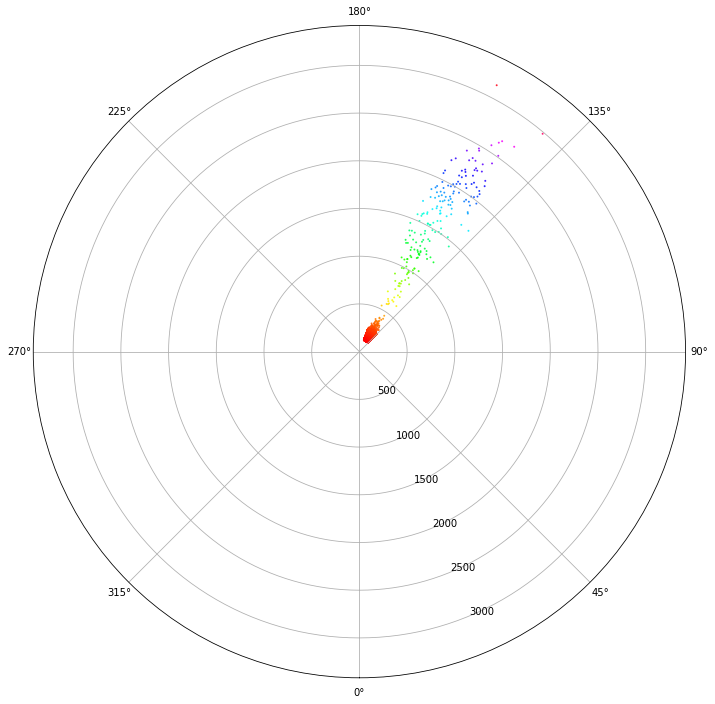

In [90]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(theta, r, c=colors, s=1, cmap='hsv', alpha=0.75)
ax.set_theta_zero_location('S')

#ax.set_thetamin(90)
#ax.set_thetamax(225)